In [1]:
!pip install plotly tfa-nightly tqdm numpy matplotlib

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Subtract, Dropout, ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers
import tensorflow_addons as tfa
from tqdm.notebook import tqdm
import tensorflow.keras.backend as K


In [3]:
plt.rcParams['figure.figsize'] = (9, 5)

In [4]:
tf.random.set_seed(0)
np.random.seed(0)

noise_std_train = (0, 55)
noise_std_val = 30
batch_size = 32
im_size = 128

# Code to generate a dataset that contains images with vertical lines and others with horizontal lines
def generate_images(im_size=128, prop_bands=0.2):
    while True:
        im = np.zeros((im_size, im_size), dtype=np.float64)
        band_locations = np.random.randint(0, im_size, int(prop_bands * im_size))
        p = np.random.uniform() # between 0 and 1
        if p >= 0.5:
          im[:, band_locations] = 1.0
        else:
          im[band_locations, :] = 1.0
        yield im


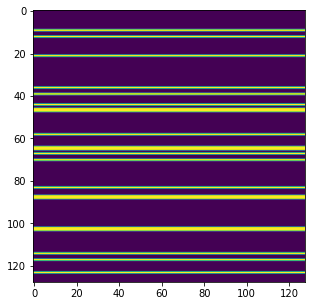

In [5]:
plt.figure()
plt.imshow(next(generate_images()))

In [6]:
vert_hor_ds = tf.data.Dataset.from_generator(
    generate_images, 
    tf.float32, 
    tf.TensorShape([im_size, im_size]),
    args=(im_size, 0.2)
).map(lambda x: x[..., None], num_parallel_calls=tf.data.experimental.AUTOTUNE)

def add_noise_function(noise_std_range):
    if not isinstance(noise_std_range, tuple):
        noise_std_range = (noise_std_range, noise_std_range)
    def add_noise(image):
        noise_std = tf.random.uniform(
            (1,),
            minval=noise_std_range[0],
            maxval=noise_std_range[1],
        )
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=noise_std/255, dtype=tf.float32)
        return image + noise
    return add_noise

add_noise_train = add_noise_function(noise_std_train)
add_noise_val = add_noise_function(noise_std_val)

vert_hor_ds_train = vert_hor_ds.map(
    lambda patch: (add_noise_train(patch), patch),
    num_parallel_calls=tf.data.experimental.AUTOTUNE,
).batch(batch_size).repeat().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

vert_hor_ds_val = vert_hor_ds.map(
    lambda patch: (add_noise_val(patch), patch),
    num_parallel_calls=tf.data.experimental.AUTOTUNE,
).batch(batch_size).repeat().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

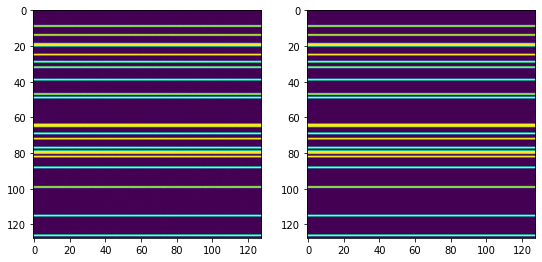

In [7]:
fig, axs = plt.subplots(1, 2)
training_example = next(iter(vert_hor_ds_train))
axs[0].imshow(np.squeeze(training_example[0][0]), vmin=0, vmax=1)
axs[1].imshow(np.squeeze(training_example[1][0]), vmin=0, vmax=1)

In [8]:
class SingularValuesConstraint(tf.keras.constraints.Constraint):
  """Hard thresholding of singular values"""

  def __init__(self, thr_value = 0.3, axis = 0, ff_size = 25, n_filters = 16):
    self.thr_value = thr_value
    self.axis = axis
    self.ff_size = ff_size
    self.n_filters = n_filters

  def __call__(self, w):
    w_reshaped = tf.reshape(w, [-1, self.ff_size, self.n_filters])
    s, u, v = tf.linalg.svd(w_reshaped)
    thr = self.thr_value*s[0]
    s=tf.where(s < thr, 0.0, s)
    w_reshaped=tf.matmul(u,tf.matmul(tf.linalg.diag(s),v,adjoint_b=True))
    w = tf.reshape(w_reshaped, [5, 5, 1, 16])
    return w

  def get_config(self):
    return {'thr_value': self.thr_value, 'axis': self.axis}

In [9]:
tf.keras.initializers.GlorotUniform(seed=0)


class DropConv(Model):
  def __init__(self, n_filters=1, drop_rate=0., **kwargs):
    super(DropConv, self).__init__(**kwargs)
    #initializer = tf.keras.initializers.Constant(1/25)
    self.decomposition = Conv2D(
      n_filters,
      5,
      padding='valid',
      activation='linear',
      #kernel_initializer=initializer,
      #kernel_constraint=constraint,
      use_bias=False,
    )
 
    self.nl = ReLU()
    self.drop = Dropout(drop_rate, noise_shape=(batch_size, 1, 1, n_filters)) # omits certain neurons
    self.paddings = tf.constant([(0,0), (2, 2), (2, 2), (0, 0)])

  def call(self, inputs):
    im_padded = tf.pad(inputs, self.paddings, 'SYMMETRIC')
    im_conv = self.decomposition(im_padded)
    im_drop = self.drop(im_conv)
    im_nl = self.nl(im_drop)
    return im_nl

In [10]:
class LinearFiltersCombine(Model):
  def __init__(self, n_filters=1, drop_rate=0., **kwargs):
    super(LinearFiltersCombine, self).__init__(**kwargs)

    self.DropConv1 = DropConv(n_filters, drop_rate)
    #self.DropConv2 = DropConv(n_filters, drop_rate)
    #self.DropConv3 = DropConv(n_filters, drop_rate)
    #self.DropConv4 = DropConv(n_filters, drop_rate)
    self.linear_combination1 = Conv2D(1, 1, use_bias=True)
    self.linear_combination2 = Conv2D(1, 1, use_bias=True)
  
  def call(self, inputs):
    im_dropconv1 = self.DropConv1(inputs)
    #im_dropconv2 = self.DropConv2(im_dropconv1)
    #im_dropconv3 = self.DropConv3(im_dropconv2)
    #im_dropconv4 = self.DropConv4(im_dropconv3)
    linear = self.linear_combination1(im_dropconv1)
    res = self.linear_combination2(linear)
    return res

base_f = 4
model = LinearFiltersCombine(n_filters=base_f**2, drop_rate=0.9)
  # model.build()

def tf_psnr(y_true, y_pred):
  return tf.image.psnr(y_true, y_pred, 1.0)

def tf_ssim(y_true, y_pred):
  return tf.image.ssim(y_true, y_pred, 1.0)

model.compile(loss='mse', optimizer=Adam(lr=1e-3), metrics=[tf_psnr, tf_ssim])


In [11]:
model(tf.zeros([1, 32, 32, 1])).shape

TensorShape([1, 32, 32, 1])

In [12]:
tqdm_cb = tfa.callbacks.TQDMProgressBar(metrics_format="{name}: {value:e}")
tqdm_cb.tqdm = tqdm

In [13]:

model.fit(
    vert_hor_ds_train, 
    steps_per_epoch=200, 
    epochs=15,
    validation_data=vert_hor_ds_val,
    validation_steps=1,
    verbose=0,
    callbacks=[tqdm_cb,],
    shuffle=False,
)

Epoch 1/15



Epoch 2/15



Epoch 3/15



Epoch 4/15



Epoch 5/15



Epoch 6/15



Epoch 7/15



Epoch 8/15



Epoch 9/15



Epoch 10/15



Epoch 11/15



Epoch 12/15



Epoch 13/15



Epoch 14/15



Epoch 15/15


In [14]:
metrics = model.evaluate(vert_hor_ds_val, steps=300)

300/300 [==============================] - 7s 25ms/step - loss: 0.0526 - tf_psnr: 12.7964 - tf_ssim: 0.4868


Model: "linear_filters_combine"
________________________________________________________________________________________________________________________
Layer (type)                                          Output Shape                                    Param #           
drop_conv (DropConv)                                  multiple                                        400               
________________________________________________________________________________________________________________________
conv2d_1 (Conv2D)                                     multiple                                        17                
________________________________________________________________________________________________________________________
conv2d_2 (Conv2D)                                     multiple                                        2                 
Total params: 419
Trainable params: 419
Non-trainable params: 0
_________________________________________________________

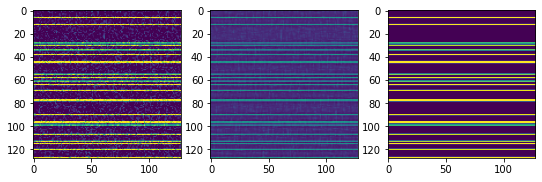

In [15]:
print(model.summary(line_length=120))

example_val = next(iter(vert_hor_ds_val))
denoised_image = model.predict_on_batch(example_val[0])

fig, axs = plt.subplots(1, 3)
axs[0].imshow(np.squeeze(example_val[0][0]), vmin=0, vmax=1)
axs[1].imshow(np.squeeze(denoised_image[0]), vmin=0, vmax=1)
axs[2].imshow(np.squeeze(example_val[1][0]), vmin=0, vmax=1)

## Filters visualization

In [20]:
decomp_kernels = model.layers[0].get_weights()[0]
recomb_kernels = model.layers[1].get_weights()[0]

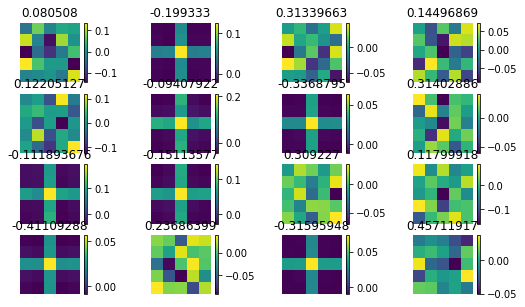

In [21]:
fig, axs = plt.subplots(base_f, base_f, sharex=True, sharey=True)
for i in range(base_f):
  for j in range(base_f):
    im = axs[i, j].imshow(np.squeeze(decomp_kernels[..., 0, i * base_f + j]))
    axs[i, j].axis('off')
    axs[i, j].set_title(np.squeeze(recomb_kernels[..., i * base_f + j, 0]))
    fig.colorbar(im, ax=axs[i, j])

    

In [ ]:

plt.figure()
plt.imshow(np.squeeze(np.dot(decomp_kernels[:, :, 0], np.squeeze(recomb_kernels))))
plt.colorbar()

In [ ]:
np.dot(decomp_kernels[:, :, 0], np.squeeze(recomb_kernels))